In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 33.9 MB/s eta 0:00:00


In [ ]:
#
"""\\
Nested CV (Outer = LOOCV) for SVR regression, NO SCALING
- Inner CV tunes kernel + SVR hyperparams (C, epsilon, gamma)
- Per fingerprint (Morgan, MACCS, AtomPairs, Torsion, Avalon, Daylight)
- Select overall best config by outer OOF R² (tie-break: RMSE)
- Refit best on all 63 and predict blind set
"""

from pathlib import Path
import sys, json, statistics
import numpy as np
import pandas as pd

# Quiet RDKit logs
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.svm import SVR
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# ===================== CONFIG =====================
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"   # set to None to skip blind prediction
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_loocv_svr_noscale")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Fingerprints
FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]

# Inner CV
INNER_FOLDS   = 5
RANDOM_SEED   = 0

# Small, safe hyperparameter grid (kept modest for n=63)
PARAM_GRID = [
    # linear kernel (no gamma)
    {"kernel": ["linear"], "C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5]},
    # RBF kernel
    {"kernel": ["rbf"], "C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]},
    # sigmoid kernel
    {"kernel": ["sigmoid"], "C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]},
]

# ================== Versions log ==================
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {
            "python": sys.version,
            "sklearn": sklearn.__version__,
            "rdkit": rdkit.__version__,
            "numpy": np.__version__,
            "pandas": pd.__version__,
        }
    except Exception:
        ver = {"python": sys.version}
    with open(OUT_DIR/"versions.json", "w") as f:
        json.dump(ver, f, indent=2)

# ============== Fingerprint helpers ===============
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan":
        fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS":
        fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs":
        fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion":
        fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon":
        fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight":
        fps = [fp_bits_daylight(m) for m in mols]
    else:
        raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([np.asarray(homo, np.float32), np.asarray(lumo, np.float32)])
    return np.hstack([X_bits, E])

# ================== Nested LOOCV ==================
def nested_loocv_for_fp(X, y):
    """
    Outer: LOOCV
    Inner: KFold(INNER_FOLDS) GridSearchCV over kernels + hyperparams
    Returns OOF predictions, selected params per outer fold
    """
    loo = LeaveOneOut()
    y_hat = np.zeros_like(y, dtype=float)
    selections = []

    for outer_idx, (tr, te) in enumerate(loo.split(X)):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        base = SVR()
        gs = GridSearchCV(
            estimator=base,
            param_grid=PARAM_GRID,
            scoring="r2",
            cv=inner,
            n_jobs=None,
            verbose=0
        )
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        y_hat[te] = best.predict(Xte)

        sel = gs.best_params_.copy()
        selections.append(sel)

    # metrics on OOF preds
    r2 = float(r2_score(y, y_hat))
    rmse = float(np.sqrt(mean_squared_error(y, y_hat)))
    mae = float(mean_absolute_error(y, y_hat))
    return y_hat, selections, r2, rmse, mae

def mode_params(selections):
    """Pick the most frequently selected hyperparameter dict across outer folds."""
    # normalize dicts into tuples for hashing
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

def main():
    log_versions()

    # ---- Load training ----
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL, HOMO_COL, LUMO_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    ok = [m is not None for m in mols]
    if not all(ok):
        bad = [i for i, t in enumerate(ok) if not t]
        raise ValueError(f"Unparsable SMILES rows: {bad}")
    y = df[TARGET_COL].astype(float).values
    homo = df[HOMO_COL].astype(float).values
    lumo = df[LUMO_COL].astype(float).values

    # ---- Run nested LOOCV per fingerprint ----
    rows = []
    all_selections = {}
    for fp in FINGERPRINTS:
        X = build_features(mols, fp, homo, lumo)
        y_hat, selections, r2, rmse, mae = nested_loocv_for_fp(X, y)
        all_selections[fp] = selections
        rows.append({"fingerprint": fp, "outer_oof_r2": r2, "outer_oof_rmse": rmse, "outer_oof_mae": mae})

        # save per-fp OOF preds
        out_oof = OUT_DIR / f"oof_preds_{fp}.csv"
        pd.DataFrame({"y_true": y, "y_pred_oof": y_hat}).to_csv(out_oof, index=False)

        # save selections per outer fold
        pd.DataFrame(selections).to_csv(OUT_DIR / f"inner_selections_{fp}.csv", index=False)

    summary = pd.DataFrame(rows).sort_values(by=["outer_oof_r2","outer_oof_rmse"], ascending=[False, True])
    summary.to_csv(OUT_DIR / "summary_nested_loocv.csv", index=False)
    print(summary)

    # ---- Choose the overall best fingerprint ----
    best_fp = summary.iloc[0]["fingerprint"]
    print(f"\nBest fingerprint by outer OOF R²: {best_fp}")

    # ---- Choose final hyperparameters: the mode across outer folds for that FP ----
    final_params = mode_params(all_selections[best_fp])
    print("Final (mode) hyperparameters:", final_params)

    # ---- Refit final model on ALL data ----
    X_all = build_features(mols, best_fp, homo, lumo)
    final_model = SVR(**final_params).fit(X_all, y)
    tag = f"{best_fp}_{final_params.get('kernel','svr')}".replace(" ","")
    dump(final_model, OUT_DIR / f"final_model_{tag}.joblib")

    # ---- Blind predictions (optional) ----
    if NEW_CSV is not None:
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok2 = [m is not None for m in new_mols]
        bdf = bdf.loc[ok2].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok2) if t]
        new_homo = bdf[NEW_HOMO_COL].astype(float).values
        new_lumo = bdf[NEW_LUMO_COL].astype(float).values

        X_new = build_features(new_mols, best_fp, new_homo, new_lumo)
        y_pred = final_model.predict(X_new)
        pd.DataFrame({NEW_LABEL_COL: bdf[NEW_LABEL_COL].values, "y_pred": y_pred}).to_csv(
            OUT_DIR / "blind_predictions.csv", index=False
        )

if __name__ == "__main__":
    main()


  fingerprint  outer_oof_r2  outer_oof_rmse  outer_oof_mae
3     Torsion      0.329402        0.473901       0.348948
5    Daylight      0.323771        0.475886       0.329890
2   AtomPairs      0.249493        0.501341       0.377230
1       MACCS      0.216942        0.512098       0.402017
4      Avalon      0.178559        0.524499       0.384728
0      Morgan      0.158114        0.530986       0.388150

Best fingerprint by outer OOF R²: Torsion
Final (mode) hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'kernel': 'linear'}


In [ ]:
# -*- coding: utf-8 -*-
"""
Nested CV (Outer = Repeated 5x5) for SVR regression, NO SCALING
- Inner CV tunes kernel + SVR hyperparams (C, epsilon, gamma)
- Per fingerprint (Morgan, MACCS, AtomPairs, Torsion, Avalon, Daylight)
- Select best by mean outer R² (tie-break: lower RMSE), refit on all 63, predict blind
"""

from pathlib import Path
import sys, json, statistics
import numpy as np
import pandas as pd

from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.svm import SVR
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump

# ===================== CONFIG =====================
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"   # set to None to skip blind prediction
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_repkfold_svr_noscale")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]

# Outer CV
OUTER_FOLDS  = 5
OUTER_REPEATS= 5
RANDOM_SEED  = 0

# Inner CV
INNER_FOLDS  = 5

PARAM_GRID = [
    {"kernel": ["linear"], "C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5]},
    {"kernel": ["rbf"], "C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]},
    {"kernel": ["sigmoid"], "C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]},
]

# ================== Versions log ==================
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {
            "python": sys.version,
            "sklearn": sklearn.__version__,
            "rdkit": rdkit.__version__,
            "numpy": np.__version__,
            "pandas": pd.__version__,
        }
    except Exception:
        ver = {"python": sys.version}
    with open(OUT_DIR/"versions.json", "w") as f:
        json.dump(ver, f, indent=2)

# ============== Fingerprint helpers ===============
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan":
        fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS":
        fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs":
        fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion":
        fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon":
        fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight":
        fps = [fp_bits_daylight(m) for m in mols]
    else:
        raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([np.asarray(homo, np.float32), np.asarray(lumo, np.float32)])
    return np.hstack([X_bits, E])

# ============ Nested Repeated 5x5 per-FP ===========
def nested_repkfold_for_fp(X, y):
    outer = RepeatedKFold(n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED)

    r2s, rmses, maes = [], [], []
    selections = []  # inner best params per outer split

    for k, (tr, te) in enumerate(outer.split(X, y)):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        gs = GridSearchCV(
            estimator=SVR(),
            param_grid=PARAM_GRID,
            scoring="r2",
            cv=inner,
            n_jobs=None,
            verbose=0
        )
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        selections.append(gs.best_params_.copy())

        y_pred = best.predict(Xte)
        r2s.append(r2_score(yte, y_pred))
        rmses.append(np.sqrt(mean_squared_error(yte, y_pred)))
        maes.append(mean_absolute_error(yte, y_pred))

    return {
        "outer_r2_mean": float(np.mean(r2s)),
        "outer_r2_std":  float(np.std(r2s)),
        "outer_rmse_mean": float(np.mean(rmses)),
        "outer_rmse_std":  float(np.std(rmses)),
        "outer_mae_mean":  float(np.mean(maes)),
        "outer_mae_std":   float(np.std(maes)),
        "selections": selections
    }

def mode_params(selections):
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

def main():
    log_versions()

    # ---- Load training ----
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL, HOMO_COL, LUMO_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    ok = [m is not None for m in mols]
    if not all(ok):
        bad = [i for i, t in enumerate(ok) if not t]
        raise ValueError(f"Unparsable SMILES rows: {bad}")
    y = df[TARGET_COL].astype(float).values
    homo = df[HOMO_COL].astype(float).values
    lumo = df[LUMO_COL].astype(float).values

    # ---- Nested repeated 5x5 per fingerprint ----
    rows = []
    all_selections = {}
    for fp in FINGERPRINTS:
        X = build_features(mols, fp, homo, lumo)
        res = nested_repkfold_for_fp(X, y)
        all_selections[fp] = res["selections"]
        rows.append({
            "fingerprint": fp,
            "outer_r2_mean": res["outer_r2_mean"],
            "outer_r2_std":  res["outer_r2_std"],
            "outer_rmse_mean": res["outer_rmse_mean"],
            "outer_rmse_std":  res["outer_rmse_std"],
            "outer_mae_mean":  res["outer_mae_mean"],
            "outer_mae_std":   res["outer_mae_std"],
        })
        # save selections table per FP
        pd.DataFrame(res["selections"]).to_csv(OUT_DIR / f"inner_selections_{fp}.csv", index=False)

    summary = pd.DataFrame(rows).sort_values(
        by=["outer_r2_mean","outer_rmse_mean"], ascending=[False, True]
    )
    summary.to_csv(OUT_DIR / "summary_nested_repkfold.csv", index=False)
    print(summary)

    # ---- Choose the overall best fingerprint ----
    best_fp = summary.iloc[0]["fingerprint"]
    print(f"\nBest fingerprint by outer mean R²: {best_fp}")

    # ---- Final hyperparameters: mode across outer selections for that FP ----
    final_params = mode_params(all_selections[best_fp])
    print("Final (mode) hyperparameters:", final_params)

    # ---- Refit on ALL data ----
    X_all = build_features(mols, best_fp, homo, lumo)
    final_model = SVR(**final_params).fit(X_all, y)
    tag = f"{best_fp}_{final_params.get('kernel','svr')}".replace(" ","")
    dump(final_model, OUT_DIR / f"final_model_{tag}.joblib")

    # ---- Blind predictions (optional) ----
    if NEW_CSV is not None:
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok2 = [m is not None for m in new_mols]
        bdf = bdf.loc[ok2].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok2) if t]
        new_homo = bdf[NEW_HOMO_COL].astype(float).values
        new_lumo = bdf[NEW_LUMO_COL].astype(float).values

        X_new = build_features(new_mols, best_fp, new_homo, new_lumo)
        y_pred = final_model.predict(X_new)
        pd.DataFrame({NEW_LABEL_COL: bdf[NEW_LABEL_COL].values, "y_pred": y_pred}).to_csv(
            OUT_DIR / "blind_predictions.csv", index=False
        )

if __name__ == "__main__":
    main()


  fingerprint  outer_r2_mean  outer_r2_std  outer_rmse_mean  outer_rmse_std  \
3     Torsion       0.288393      0.222209         0.454719        0.095935   
5    Daylight       0.210154      0.336776         0.481076        0.133013   
4      Avalon       0.171156      0.295832         0.487555        0.091808   
2   AtomPairs       0.162491      0.270052         0.493775        0.099866   
1       MACCS       0.143546      0.251903         0.503382        0.110313   
0      Morgan       0.099186      0.292250         0.511905        0.103225   

   outer_mae_mean  outer_mae_std  
3        0.351315       0.089614  
5        0.351691       0.102407  
4        0.372202       0.076243  
2        0.386330       0.090229  
1        0.397986       0.097070  
0        0.388904       0.092243  

Best fingerprint by outer mean R²: Torsion
Final (mode) hyperparameters: {'C': 10.0, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# -*- coding: utf-8 -*-
"""
Nested classification (Outer = Repeated Stratified 5x5, Inner = Stratified 5-fold grid search)
- Labels: fixed cutoff dF/F >= 0.3 => Class 1, else 0
- Features: fingerprint bits + HOMO + LUMO (NO SCALING)
- Fingerprints: Morgan, MACCS, AtomPairs, Torsion, Avalon, Daylight
- Kernels tuned (inner CV): linear / rbf / sigmoid with modest C, gamma grids
- Selection metric: outer mean AUC (tie-break: lower AUC std, then higher F1 mean)
- Refit Top-K configs on all 63; predict blind per model + ensemble
"""

from pathlib import Path
import sys, json
import numpy as np
import pandas as pd

# Silence RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg  # modern API

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from joblib import dump, load

# ===================== CONFIG =====================
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"   # training set (63)
SMILES_COL  = "Smiles"
TARGET_CONT = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

# Blind set (set to None to skip blind predictions)
NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_cls_repkfold_topk_noscale")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Fingerprints
FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]

# Label cutoff and prediction threshold
FIXED_CUTOFF   = 0.3    # dF/F >= 0.3 => Class 1
PROB_THRESHOLD = 0.5    # probability -> class label

# Outer CV
OUTER_FOLDS   = 5
OUTER_REPEATS = 5
RANDOM_SEED   = 0

# Inner CV
INNER_FOLDS = 5

# Small, stable SVC grid (tuned inside inner CV)
PARAM_GRID = [
    {"kernel": ["linear"],  "C": [0.1, 1.0, 10.0]},
    {"kernel": ["rbf"],     "C": [0.1, 1.0, 10.0], "gamma": ["scale", 0.1, 1.0]},
    {"kernel": ["sigmoid"], "C": [0.1, 1.0, 10.0], "gamma": ["scale", 0.1, 1.0]},
]

TOP_K = 5  # number of best configs to refit

# ================= Versions =================
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {
            "python": sys.version,
            "sklearn": sklearn.__version__,
            "rdkit": rdkit.__version__,
            "numpy": np.__version__,
            "pandas": pd.__version__,
        }
    except Exception:
        ver = {"python": sys.version}
    with open(OUT_DIR / "versions.json", "w") as f:
        json.dump(ver, f, indent=2)

# ================= Fingerprints =================
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan":
        fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS":
        fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs":
        fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion":
        fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon":
        fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight":
        fps = [fp_bits_daylight(m) for m in mols]
    else:
        raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([
        np.asarray(homo, np.float32),
        np.asarray(lumo, np.float32)
    ])
    return np.hstack([X_bits, E])

# ============== Nested outer Repeated Stratified 5x5 ==============
def nested_repkfold_for_fp(X, y_bin):
    """
    Outer: RepeatedStratifiedKFold (5x5)
    Inner: StratifiedKFold (5) GridSearchCV scoring='roc_auc'
    Returns means/stds of outer metrics + inner-best selections per outer split
    """
    outer = RepeatedStratifiedKFold(n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED)
    aucs, f1s, accs = [], [], []
    selections = []

    for (tr, te) in outer.split(X, y_bin):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y_bin[tr], y_bin[te]

        inner = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        gs = GridSearchCV(
            estimator=SVC(probability=True),
            param_grid=PARAM_GRID,
            scoring="roc_auc",
            cv=inner,
            n_jobs=None,
            verbose=0
        )
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        selections.append(gs.best_params_.copy())

        # Outer test
        p_te = best.predict_proba(Xte)[:, 1]
        yhat = (p_te >= PROB_THRESHOLD).astype(int)

        aucs.append(roc_auc_score(yte, p_te))
        f1s.append(f1_score(yte, yhat, zero_division=0))
        accs.append(accuracy_score(yte, yhat))

    return {
        "outer_auc_mean": float(np.mean(aucs)),
        "outer_auc_std":  float(np.std(aucs)),
        "outer_f1_mean":  float(np.mean(f1s)),
        "outer_f1_std":   float(np.std(f1s)),
        "outer_acc_mean": float(np.mean(accs)),
        "outer_acc_std":  float(np.std(accs)),
        "selections": selections
    }

def mode_params(selections):
    """Final params = most frequently chosen inner-best across outer splits."""
    import statistics
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

# ===================== Main =====================
def main():
    log_versions()

    # ---- Load training ----
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_CONT, HOMO_COL, LUMO_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    ok = [m is not None for m in mols]
    if not all(ok):
        bad = [i for i, t in enumerate(ok) if not t]
        raise ValueError(f"Unparsable SMILES rows: {bad}")

    y_cont = df[TARGET_CONT].astype(float).values
    homo   = df[HOMO_COL].astype(float).values
    lumo   = df[LUMO_COL].astype(float).values

    # ---- Binarize with fixed cutoff ----
    y_bin = (y_cont >= FIXED_CUTOFF).astype(int)
    counts = np.bincount(y_bin)
    n0 = int(counts[0]) if len(counts) > 0 else 0
    n1 = int(counts[1]) if len(counts) > 1 else 0
    print(f"✅ Using fixed cutoff dF/F >= {FIXED_CUTOFF} → Class 1")
    print(f"Training class counts (0,1): ({n0}, {n1})\n")

    # ---- Nested CV per fingerprint ----
    rows = []
    selections_map = {}
    for fp in FINGERPRINTS:
        print(f"Evaluating fingerprint: {fp}")
        X = build_features(mols, fp, homo, lumo)
        res = nested_repkfold_for_fp(X, y_bin)
        selections_map[fp] = res["selections"]
        rows.append({
            "fingerprint": fp,
            "outer_auc_mean": res["outer_auc_mean"],
            "outer_auc_std":  res["outer_auc_std"],
            "outer_f1_mean":  res["outer_f1_mean"],
            "outer_f1_std":   res["outer_f1_std"],
            "outer_acc_mean": res["outer_acc_mean"],
            "outer_acc_std":  res["outer_acc_std"],
        })
        pd.DataFrame(res["selections"]).to_csv(OUT_DIR / f"inner_selections_{fp}.csv", index=False)

    cv_df = pd.DataFrame(rows).sort_values(
        by=["outer_auc_mean", "outer_auc_std", "outer_f1_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)
    cv_df.to_csv(OUT_DIR / "summary_nested_repkfold_cls.csv", index=False)
    print("\n=== CV summary (sorted) ===")
    print(cv_df)

    # ---- Build the candidate list = every FP's mode params ----
    candidates = []
    for fp in cv_df["fingerprint"]:
        params = mode_params(selections_map[fp])
        # Attach the outer summary metrics for ranking
        row = cv_df.loc[cv_df["fingerprint"] == fp].iloc[0].to_dict()
        candidates.append({"fingerprint": fp, "params": params, **row})

    cand_df = pd.DataFrame(candidates).sort_values(
        by=["outer_auc_mean", "outer_auc_std", "outer_f1_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)
    cand_df.to_csv(OUT_DIR / "candidates_ranked.csv", index=False)

    # ---- Select Top-K configs ----
    topk = cand_df.head(min(TOP_K, len(cand_df))).copy()
    topk.insert(0, "rank", np.arange(1, len(topk) + 1))
    topk.to_csv(OUT_DIR / "top_models.csv", index=False)
    print("\n=== Top-K selected ===")
    print(topk[["rank", "fingerprint", "params", "outer_auc_mean", "outer_auc_std", "outer_f1_mean"]])

    # ---- Refit Top-K on ALL training data; save models ----
    print("\nRefitting Top-K on all 63...")
    saved = []
    for _, row in topk.iterrows():
        fp   = row["fingerprint"]
        prm  = row["params"]
        Xall = build_features(mols, fp, homo, lumo)
        clf  = SVC(probability=True, **prm).fit(Xall, y_bin)
        tag  = f"{fp}_{prm.get('kernel','svc')}".replace(" ", "")
        path = OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}.joblib"
        dump(clf, path)
        saved.append((path, fp, prm))
        print(f"Saved: {path}")

    # ---- Blind predictions: per-model + ensemble ----
    if NEW_CSV is not None:
        print("\nBlind predictions...")
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok2 = [m is not None for m in new_mols]
        bdf = bdf.loc[ok2].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok2) if t]
        new_homo = bdf[NEW_HOMO_COL].astype(float).values
        new_lumo = bdf[NEW_LUMO_COL].astype(float).values

        # Per-model probabilities
        per_model = {}
        for path, fp, prm in saved:
            clf = load(path)
            X_new = build_features(new_mols, fp, new_homo, new_lumo)
            p = clf.predict_proba(X_new)[:, 1]
            col = Path(path).stem  # nice column name
            per_model[col] = p

        per_df = pd.DataFrame(per_model)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_df.to_csv(OUT_DIR / "blind_per_model.csv", index=False)

        # Ensemble statistics
        P = np.column_stack([per_model[c] for c in per_model.keys()])
        ens_mean   = P.mean(axis=1)
        ens_median = np.median(P, axis=1)
        ens_vote   = (P >= PROB_THRESHOLD).astype(int).mean(axis=1) >= 0.5  # majority
        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   ens_mean,
            "Ensemble_median": ens_median,
            "Ensemble_vote":   ens_vote.astype(int)
        })
        ens_df.to_csv(OUT_DIR / "blind_ensemble.csv", index=False)

        print(f"Saved: {OUT_DIR/'blind_per_model.csv'}")
        print(f"Saved: {OUT_DIR/'blind_ensemble.csv'}")

    print("\nDone.")

if __name__ == "__main__":
    main()


# inner loop-hyperparameters, outer CV-kernels, fingerprints

In [ ]:
# -*- coding: utf-8 -*-
"""
Nested CV for regression (SVR), NO SCALING
Outer = LOOCV (chooses fingerprint × kernel families by unbiased OOF performance)
Inner = KFold (tunes numeric hyperparameters ONLY: C, epsilon, gamma when applicable)

After evaluating all families, pick Top-5 by outer OOF R^2 (tie-break: lower RMSE),
refit each on all 63, predict blind per-model, and write an ensemble (mean/median/std).
"""

from pathlib import Path
import sys, json, statistics
import numpy as np
import pandas as pd

# Silence RDKit chatter
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.svm import SVR
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# ---------------------- CONFIG ----------------------
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"   # training (63)
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"   # blind set (set to None to skip)
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_outer_loocv_top5_reg")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Inner CV
INNER_FOLDS = 5
RANDOM_SEED = 0

# Numeric hyperparameter grids (kernel fixed per run)
GRID_LINEAR  = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5]}
GRID_RBF     = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]}
GRID_SIGMOID = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]}

TOP_K = 5

# ---------------- Versions for reproducibility ----------------
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {"python": sys.version, "sklearn": sklearn.__version__, "rdkit": rdkit.__version__,
               "numpy": np.__version__, "pandas": pd.__version__}
    except Exception:
        ver = {"python": sys.version}
    (OUT_DIR / "versions.json").write_text(json.dumps(ver, indent=2))

# ---------------- Fingerprint helpers (warning-free) ----------------
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None: fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan": fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS": fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs": fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion": fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon": fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight": fps = [fp_bits_daylight(m) for m in mols]
    else: raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([np.asarray(homo, np.float32), np.asarray(lumo, np.float32)])
    return np.hstack([X_bits, E])

# --------------- Outer LOOCV with inner tuning (kernel fixed) ---------------
def inner_grid_for_kernel(kernel):
    if kernel == "linear":  return GRID_LINEAR,  SVR(kernel="linear")
    if kernel == "rbf":     return GRID_RBF,     SVR(kernel="rbf")
    if kernel == "sigmoid": return GRID_SIGMOID, SVR(kernel="sigmoid")
    raise ValueError(kernel)

def nested_outer_loocv_family(X, y, kernel):
    """
    For a fixed kernel: Outer = LOOCV; Inner = KFold(INNER_FOLDS) GridSearchCV over numeric params.
    Returns: OOF predictions, list of best-param dicts per outer fold, OOF R2/RMSE/MAE
    """
    grid, base = inner_grid_for_kernel(kernel)
    loo = LeaveOneOut()

    y_oof = np.zeros_like(y, dtype=float)
    selections = []

    for tr, te in loo.split(X):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        gs = GridSearchCV(base, param_grid=grid, scoring="r2", cv=inner, verbose=0)
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        y_oof[te] = best.predict(Xte)
        selections.append(gs.best_params_.copy())

    r2   = float(r2_score(y, y_oof))
    rmse = float(np.sqrt(mean_squared_error(y, y_oof)))
    mae  = float(mean_absolute_error(y, y_oof))
    return y_oof, selections, r2, rmse, mae

def mode_params(selections):
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

def main():
    log_versions()

    # Load training
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL, HOMO_COL, LUMO_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    if not all(mols): raise ValueError("Some SMILES could not be parsed.")
    y    = df[TARGET_COL].astype(float).values
    homo = df[HOMO_COL].astype(float).values
    lumo = df[LUMO_COL].astype(float).values

    rows = []
    selections_map = {}  # key: (fp,kernel) -> list of inner-best param dicts (per outer fold)

    # Evaluate all fingerprint × kernel families
    for fp in FINGERPRINTS:
        X = build_features(mols, fp, homo, lumo)
        for kernel in KERNELS:
            y_oof, selections, r2, rmse, mae = nested_outer_loocv_family(X, y, kernel)
            selections_map[(fp, kernel)] = selections
            rows.append({"fingerprint": fp, "kernel": kernel,
                         "outer_oof_r2": r2, "outer_oof_rmse": rmse, "outer_oof_mae": mae})
            # Save OOF preds and inner selections (for transparency)
            pd.DataFrame({"y_true": y, "y_pred_oof": y_oof}).to_csv(
                OUT_DIR / f"oof_{fp}_{kernel}.csv", index=False
            )
            pd.DataFrame(selections).to_csv(
                OUT_DIR / f"inner_selections_{fp}_{kernel}.csv", index=False
            )

    # Rank families by outer OOF performance
    summary = pd.DataFrame(rows).sort_values(
        by=["outer_oof_r2", "outer_oof_rmse"], ascending=[False, True]
    ).reset_index(drop=True)
    summary.to_csv(OUT_DIR / "summary_outer_loocv_families.csv", index=False)
    print("\nTop families by LOOCV OOF R^2:")
    print(summary.head(10))

    # Select Top-K families
    topk = summary.head(min(TOP_K, len(summary))).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))
    topk.to_csv(OUT_DIR / "top_models.csv", index=False)

    # Refit Top-K on ALL 63 and save models
    saved = []
    for _, row in topk.iterrows():
        fp, kernel = row["fingerprint"], row["kernel"]
        params = mode_params(selections_map[(fp, kernel)])  # stable choice
        X_all = build_features(mols, fp, homo, lumo)
        model = SVR(kernel=kernel, **params).fit(X_all, y)
        tag = f"{fp}_{kernel}".replace(" ", "")
        path = OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}.joblib"
        dump(model, path)
        saved.append((path, fp, kernel, params))
        print(f"Saved: {path}  params={params}")

    # Blind predictions per-model + ensemble
    if NEW_CSV is not None:
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok = [m is not None for m in new_mols]
        bdf = bdf.loc[ok].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok) if t]
        new_homo = bdf[NEW_HOMO_COL].astype(float).values
        new_lumo = bdf[NEW_LUMO_COL].astype(float).values

        # Per-model predictions
        per_cols = {}
        for path, fp, kernel, params in saved:
            mdl = load(path)
            X_new = build_features(new_mols, fp, new_homo, new_lumo)
            y_pred = mdl.predict(X_new)
            per_cols[Path(path).stem] = y_pred

        per_df = pd.DataFrame(per_cols)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_df.to_csv(OUT_DIR / "blind_per_model.csv", index=False)

        # Ensemble (mean / median / std)
        P = np.column_stack([per_cols[c] for c in per_cols.keys()])
        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   P.mean(axis=1),
            "Ensemble_median": np.median(P, axis=1),
            "Ensemble_std":    P.std(axis=1, ddof=1) if P.shape[1] > 1 else np.zeros(P.shape[0])
        })
        ens_df.to_csv(OUT_DIR / "blind_ensemble.csv", index=False)
        print(f"\nSaved: {OUT_DIR/'blind_per_model.csv'}")
        print(f"Saved: {OUT_DIR/'blind_ensemble.csv'}")

    print("\nDone.")

if __name__ == "__main__":
    main()



Top families by LOOCV OOF R^2:
  fingerprint   kernel  outer_oof_r2  outer_oof_rmse  outer_oof_mae
0     Torsion      rbf      0.489899        0.413318       0.314450
1   AtomPairs   linear      0.362633        0.462010       0.346446
2     Torsion   linear      0.351398        0.466064       0.344199
3      Avalon   linear      0.342594        0.469216       0.359969
4   AtomPairs      rbf      0.338692        0.470607       0.354913
5    Daylight   linear      0.327570        0.474547       0.328122
6   AtomPairs  sigmoid      0.324022        0.475798       0.340829
7      Avalon  sigmoid      0.295189        0.485839       0.338375
8      Avalon      rbf      0.264632        0.496259       0.371693
9      Morgan   linear      0.263391        0.496678       0.372613
Saved: outputs_nested_outer_loocv_top5_reg/final_model_01_Torsion_rbf.joblib  params={'C': 10.0, 'epsilon': 0.01, 'gamma': 'scale'}
Saved: outputs_nested_outer_loocv_top5_reg/final_model_02_AtomPairs_linear.joblib  param

In [ ]:
# -*- coding: utf-8 -*-
"""
Nested CV for regression (SVR), NO SCALING
Outer = Repeated KFold (5 folds × 5 repeats) compares fingerprint × kernel families
Inner = KFold (tunes numeric hyperparameters ONLY: C, epsilon, gamma when applicable)

After evaluating all families, pick Top-5 by outer mean R^2 (tie-break: lower RMSE mean),
refit each on all 63, predict blind per-model, and write an ensemble (mean/median/std).
"""

from pathlib import Path
import sys, json, statistics
import numpy as np
import pandas as pd

from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.svm import SVR
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# ---------------------- CONFIG ----------------------
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_outer_repkfold_top5_reg")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Outer CV
OUTER_FOLDS   = 5
OUTER_REPEATS = 5
RANDOM_SEED   = 0

# Inner CV
INNER_FOLDS = 5

# Numeric grids (kernel fixed per run)
GRID_LINEAR  = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5]}
GRID_RBF     = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]}
GRID_SIGMOID = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]}

TOP_K = 5

# ---------------- Versions ----------------
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {"python": sys.version, "sklearn": sklearn.__version__, "rdkit": rdkit.__version__,
               "numpy": np.__version__, "pandas": pd.__version__}
    except Exception:
        ver = {"python": sys.version}
    (OUT_DIR / "versions.json").write_text(json.dumps(ver, indent=2))

# ---------------- Fingerprint helpers ----------------
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None: fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan": fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS": fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs": fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion": fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon": fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight": fps = [fp_bits_daylight(m) for m in mols]
    else: raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([np.asarray(homo, np.float32), np.asarray(lumo, np.float32)])
    return np.hstack([X_bits, E])

# --------------- Outer repeated k-fold with inner tuning (kernel fixed) ---------------
def inner_grid_for_kernel(kernel):
    if kernel == "linear":  return GRID_LINEAR,  SVR(kernel="linear")
    if kernel == "rbf":     return GRID_RBF,     SVR(kernel="rbf")
    if kernel == "sigmoid": return GRID_SIGMOID, SVR(kernel="sigmoid")
    raise ValueError(kernel)

def nested_outer_repkfold_family(X, y, kernel):
    grid, base = inner_grid_for_kernel(kernel)
    outer = RepeatedKFold(n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED)

    r2s, rmses, maes = [], [], []
    selections = []

    for tr, te in outer.split(X, y):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        gs = GridSearchCV(base, param_grid=grid, scoring="r2", cv=inner, verbose=0)
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        selections.append(gs.best_params_.copy())

        y_pred = best.predict(Xte)
        r2s.append(r2_score(yte, y_pred))
        rmses.append(np.sqrt(mean_squared_error(yte, y_pred)))
        maes.append(mean_absolute_error(yte, y_pred))

    return {
        "outer_r2_mean": float(np.mean(r2s)),
        "outer_r2_std":  float(np.std(r2s)),
        "outer_rmse_mean": float(np.mean(rmses)),
        "outer_rmse_std":  float(np.std(rmses)),
        "outer_mae_mean":  float(np.mean(maes)),
        "outer_mae_std":   float(np.std(maes)),
        "selections": selections
    }

def mode_params(selections):
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

def main():
    log_versions()

    # Load training
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL, HOMO_COL, LUMO_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    if not all(mols): raise ValueError("Some SMILES could not be parsed.")
    y    = df[TARGET_COL].astype(float).values
    homo = df[HOMO_COL].astype(float).values
    lumo = df[LUMO_COL].astype(float).values

    rows = []
    selections_map = {}

    for fp in FINGERPRINTS:
        X = build_features(mols, fp, homo, lumo)
        for kernel in KERNELS:
            res = nested_outer_repkfold_family(X, y, kernel)
            selections_map[(fp, kernel)] = res["selections"]
            rows.append({
                "fingerprint": fp, "kernel": kernel,
                "outer_r2_mean": res["outer_r2_mean"], "outer_r2_std": res["outer_r2_std"],
                "outer_rmse_mean": res["outer_rmse_mean"], "outer_rmse_std": res["outer_rmse_std"],
                "outer_mae_mean": res["outer_mae_mean"], "outer_mae_std": res["outer_mae_std"],
            })
            pd.DataFrame(res["selections"]).to_csv(
                OUT_DIR / f"inner_selections_{fp}_{kernel}.csv", index=False
            )

    summary = pd.DataFrame(rows).sort_values(
        by=["outer_r2_mean", "outer_rmse_mean"], ascending=[False, True]
    ).reset_index(drop=True)
    summary.to_csv(OUT_DIR / "summary_outer_repkfold_families.csv", index=False)
    print("\nTop families by outer mean R^2:")
    print(summary.head(12))

    # Top-K families
    topk = summary.head(min(TOP_K, len(summary))).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))
    topk.to_csv(OUT_DIR / "top_models.csv", index=False)

    # Refit Top-K on ALL data
    saved = []
    for _, row in topk.iterrows():
        fp, kernel = row["fingerprint"], row["kernel"]
        params = mode_params(selections_map[(fp, kernel)])
        X_all = build_features(mols, fp, homo, lumo)
        model = SVR(kernel=kernel, **params).fit(X_all, y)
        tag = f"{fp}_{kernel}".replace(" ", "")
        path = OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}.joblib"
        dump(model, path)
        saved.append((path, fp, kernel, params))
        print(f"Saved: {path}  params={params}")

    # Blind predictions per-model + ensemble
    if NEW_CSV is not None:
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok = [m is not None for m in new_mols]
        bdf = bdf.loc[ok].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok) if t]
        new_homo = bdf[NEW_HOMO_COL].astype(float).values
        new_lumo = bdf[NEW_LUMO_COL].astype(float).values

        per_cols = {}
        for path, fp, kernel, params in saved:
            mdl = load(path)
            X_new = build_features(new_mols, fp, new_homo, new_lumo)
            y_pred = mdl.predict(X_new)
            per_cols[Path(path).stem] = y_pred

        per_df = pd.DataFrame(per_cols)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_df.to_csv(OUT_DIR / "blind_per_model.csv", index=False)

        P = np.column_stack([per_cols[c] for c in per_cols.keys()])
        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   P.mean(axis=1),
            "Ensemble_median": np.median(P, axis=1),
            "Ensemble_std":    P.std(axis=1, ddof=1) if P.shape[1] > 1 else np.zeros(P.shape[0])
        })
        ens_df.to_csv(OUT_DIR / "blind_ensemble.csv", index=False)
        print(f"\nSaved: {OUT_DIR/'blind_per_model.csv'}")
        print(f"Saved: {OUT_DIR/'blind_ensemble.csv'}")

    print("\nDone.")

if __name__ == "__main__":
    main()



Top families by outer mean R^2:
   fingerprint   kernel  outer_r2_mean  outer_r2_std  outer_rmse_mean  \
0      Torsion   linear       0.348324      0.248852         0.432752   
1      Torsion      rbf       0.325356      0.191211         0.447707   
2     Daylight   linear       0.297778      0.336801         0.451964   
3    AtomPairs   linear       0.251593      0.242539         0.467922   
4       Avalon  sigmoid       0.232538      0.181360         0.483856   
5       Avalon   linear       0.229769      0.289298         0.471423   
6    AtomPairs  sigmoid       0.224059      0.205206         0.485667   
7        MACCS   linear       0.184967      0.231178         0.489423   
8       Morgan   linear       0.183646      0.278878         0.487722   
9    AtomPairs      rbf       0.178494      0.175582         0.496601   
10    Daylight  sigmoid       0.143243      0.219992         0.510842   
11    Daylight      rbf       0.108891      0.263355         0.518311   

    outer_rmse_st

# Classification

In [ ]:
# -*- coding: utf-8 -*-
"""
Nested classification (SVC) with outer family selection and inner numeric tuning — NO SCALING
Outer = Repeated Stratified 5x5 CV chooses (fingerprint × kernel) families by unbiased performance.
Inner = Stratified 5-fold GridSearchCV tunes ONLY numeric hyperparams for the fixed kernel (C, gamma).

After evaluating all families:
  - Pick Top-5 by outer mean AUC (tie-break: lower AUC std, higher F1 mean),
  - Refit each on ALL 63 molecules,
  - Predict blind: per-model probabilities + ensemble (mean/median prob + majority vote).

Labels: fixed cutoff dF/F >= 0.3 => Class 1, else 0.
Features: fingerprint bits + HOMO + LUMO.  No scaling.
"""

from pathlib import Path
import sys, json, statistics
import numpy as np
import pandas as pd

# Quiet RDKit
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg  # modern, no deprecation

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from joblib import dump, load

# ---------------------- CONFIG ----------------------
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"  # training (63)
SMILES_COL  = "Smiles"
TARGET_CONT = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"   # blind set (set None to skip)
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_outer_repkfold_top5_cls")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Fingerprints & kernels
FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Label cutoff & decision threshold
FIXED_CUTOFF   = 0.3   # dF/F >= 0.3 -> class 1
PROB_THRESHOLD = 0.5   # convert probability -> label

# Outer CV
OUTER_FOLDS   = 5
OUTER_REPEATS = 5
RANDOM_SEED   = 0

# Inner CV
INNER_FOLDS = 5

# Numeric grids (kernel fixed per run)
GRID_LINEAR  = {"C": [0.1, 1.0, 10.0]}
GRID_RBF     = {"C": [0.1, 1.0, 10.0], "gamma": ["scale", 0.1, 1.0]}
GRID_SIGMOID = {"C": [0.1, 1.0, 10.0], "gamma": ["scale", 0.1, 1.0]}

TOP_K = 5

# ---------------- Versions ----------------
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {"python": sys.version, "sklearn": sklearn.__version__, "rdkit": rdkit.__version__,
               "numpy": np.__version__, "pandas": pd.__version__}
    except Exception:
        ver = {"python": sys.version}
    (OUT_DIR / "versions.json").write_text(json.dumps(ver, indent=2))

# ---------------- Fingerprints (warning-free) ----------------
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan": fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS": fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs": fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion": fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon": fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight": fps = [fp_bits_daylight(m) for m in mols]
    else: raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([
        np.asarray(homo, np.float32),
        np.asarray(lumo, np.float32),
    ])
    return np.hstack([X_bits, E])

# ---------------- Helpers ----------------
def grid_for_kernel(kernel):
    if kernel == "linear":  return GRID_LINEAR,  SVC(kernel="linear", probability=True)
    if kernel == "rbf":     return GRID_RBF,     SVC(kernel="rbf",    probability=True)
    if kernel == "sigmoid": return GRID_SIGMOID, SVC(kernel="sigmoid",probability=True)
    raise ValueError(kernel)

def mode_params(selections):
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

# -------- Outer repeated stratified k-fold with inner numeric tuning --------
def nested_outer_repkfold_family(X, y_bin, kernel):
    """
    For a fixed kernel: Outer = RepeatedStratifiedKFold; Inner = StratifiedKFold(INNER_FOLDS)
    GridSearchCV scoring='roc_auc' (probability-based). We also compute F1/ACC at 0.5 threshold.
    Returns mean/std of outer metrics + inner best selections per outer split.
    """
    grid, base = grid_for_kernel(kernel)
    outer = RepeatedStratifiedKFold(n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED)

    aucs, f1s, accs = [], [], []
    selections = []

    for tr, te in outer.split(X, y_bin):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y_bin[tr], y_bin[te]

        inner = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        gs = GridSearchCV(estimator=base, param_grid=grid, scoring="roc_auc", cv=inner, verbose=0)
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        selections.append(gs.best_params_.copy())

        p_te = best.predict_proba(Xte)[:, 1]
        yhat = (p_te >= PROB_THRESHOLD).astype(int)

        aucs.append(roc_auc_score(yte, p_te))
        f1s.append(f1_score(yte, yhat, zero_division=0))
        accs.append(accuracy_score(yte, yhat))

    return {
        "outer_auc_mean": float(np.mean(aucs)),
        "outer_auc_std":  float(np.std(aucs)),
        "outer_f1_mean":  float(np.mean(f1s)),
        "outer_f1_std":   float(np.std(f1s)),
        "outer_acc_mean": float(np.mean(accs)),
        "outer_acc_std":  float(np.std(accs)),
        "selections": selections
    }

# ---------------- Main ----------------
def main():
    log_versions()

    # Load training
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_CONT, HOMO_COL, LUMO_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols   = [Chem.MolFromSmiles(s) for s in smiles]
    if not all(mols):
        bad = [i for i, m in enumerate(mols) if m is None]
        raise ValueError(f"Unparsable SMILES rows: {bad}")

    y_cont = df[TARGET_CONT].astype(float).values
    homo   = df[HOMO_COL].astype(float).values
    lumo   = df[LUMO_COL].astype(float).values

    # Binarize labels
    y_bin = (y_cont >= FIXED_CUTOFF).astype(int)
    counts = np.bincount(y_bin)
    n0 = int(counts[0]) if len(counts)>0 else 0
    n1 = int(counts[1]) if len(counts)>1 else 0
    print(f"✅ Using fixed cutoff dF/F >= {FIXED_CUTOFF} → Class 1")
    print(f"Training class counts (0,1): ({n0}, {n1})\n")

    # Evaluate all (fingerprint × kernel) families
    rows = []
    selections_map = {}  # key = (fp,kernel) -> list of dicts per outer split

    for fp in FINGERPRINTS:
        print(f"Fingerprint: {fp}")
        X = build_features(mols, fp, homo, lumo)
        for kernel in KERNELS:
            res = nested_outer_repkfold_family(X, y_bin, kernel)
            selections_map[(fp, kernel)] = res["selections"]
            rows.append({
                "fingerprint": fp, "kernel": kernel,
                "outer_auc_mean": res["outer_auc_mean"], "outer_auc_std": res["outer_auc_std"],
                "outer_f1_mean":  res["outer_f1_mean"],  "outer_f1_std":  res["outer_f1_std"],
                "outer_acc_mean": res["outer_acc_mean"], "outer_acc_std": res["outer_acc_std"],
            })
            # Save inner selections (transparency)
            pd.DataFrame(res["selections"]).to_csv(
                OUT_DIR / f"inner_selections_{fp}_{kernel}.csv", index=False
            )

    # Rank families by mean AUC (tie-break: lower AUC std, higher F1 mean)
    summary = pd.DataFrame(rows).sort_values(
        by=["outer_auc_mean", "outer_auc_std", "outer_f1_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)
    summary.to_csv(OUT_DIR / "summary_outer_repkfold_families_cls.csv", index=False)
    print("\nTop families by outer mean AUC:")
    print(summary.head(12))

    # Select Top-K families
    topk = summary.head(min(TOP_K, len(summary))).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))
    topk.to_csv(OUT_DIR / "top_models.csv", index=False)

    # Refit Top-K on ALL 63 and save models
    print("\nRefitting Top-K on all 63 and saving models...")
    saved = []
    for _, row in topk.iterrows():
        fp, kernel = row["fingerprint"], row["kernel"]
        # Choose stable hyperparams: mode of inner bests across outer splits
        params = mode_params(selections_map[(fp, kernel)])
        X_all  = build_features(mols, fp, homo, lumo)
        clf    = SVC(kernel=kernel, probability=True, **params).fit(X_all, y_bin)
        tag    = f"{fp}_{kernel}".replace(" ", "")
        path   = OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}.joblib"
        dump(clf, path)
        saved.append((path, fp, kernel, params))
        print(f"Saved: {path}  params={params}")

    # Blind predictions: per-model + ensemble
    if NEW_CSV is not None:
        print("\nPredicting blind set...")
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok = [m is not None for m in new_mols]
        bdf = bdf.loc[ok].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok) if t]
        new_homo = bdf[NEW_HOMO_COL].astype(float).values
        new_lumo = bdf[NEW_LUMO_COL].astype(float).values

        # Per-model probabilities
        per_cols = {}
        for path, fp, kernel, params in saved:
            clf = load(path)
            X_new = build_features(new_mols, fp, new_homo, new_lumo)
            p = clf.predict_proba(X_new)[:, 1]  # prob of Class 1
            per_cols[Path(path).stem] = p

        per_df = pd.DataFrame(per_cols)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_df.to_csv(OUT_DIR / "blind_per_model.csv", index=False)

        # Ensemble (mean / median prob + majority vote label)
        P = np.column_stack([per_cols[c] for c in per_cols.keys()])
        ens_mean   = P.mean(axis=1)
        ens_median = np.median(P, axis=1)
        ens_vote   = (P >= PROB_THRESHOLD).astype(int).mean(axis=1) >= 0.5
        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   ens_mean,
            "Ensemble_median": ens_median,
            "Ensemble_vote":   ens_vote.astype(int)
        })
        ens_df.to_csv(OUT_DIR / "blind_ensemble.csv", index=False)

        print(f"\nSaved: {OUT_DIR/'blind_per_model.csv'}")
        print(f"Saved: {OUT_DIR/'blind_ensemble.csv'}")

    print("\nDone.")

if __name__ == "__main__":
    main()


✅ Using fixed cutoff dF/F >= 0.3 → Class 1
Training class counts (0,1): (33, 30)

Fingerprint: Morgan
Fingerprint: MACCS
Fingerprint: AtomPairs
Fingerprint: Torsion
Fingerprint: Avalon
Fingerprint: Daylight

Top families by outer mean AUC:
   fingerprint   kernel  outer_auc_mean  outer_auc_std  outer_f1_mean  \
0       Avalon   linear        0.885556       0.102947       0.841017   
1    AtomPairs   linear        0.884286       0.110495       0.863910   
2        MACCS   linear        0.874762       0.122083       0.847030   
3     Daylight   linear        0.873333       0.111060       0.806731   
4      Torsion   linear        0.873175       0.106848       0.821829   
5       Avalon      rbf        0.856032       0.115320       0.812545   
6       Morgan   linear        0.850794       0.123018       0.792755   
7    AtomPairs      rbf        0.838095       0.190678       0.846651   
8        MACCS      rbf        0.798968       0.200736       0.744346   
9     Daylight  sigmoid       

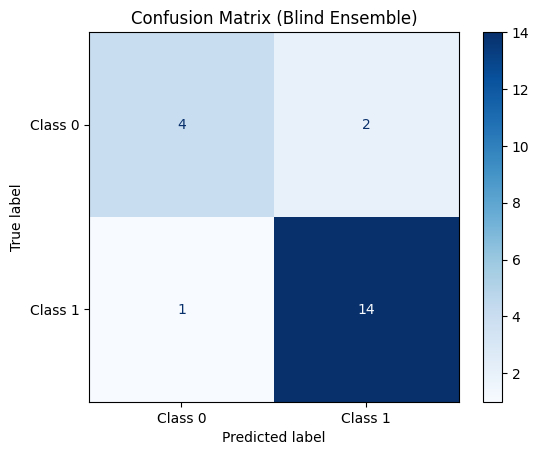

Classification Report (Blind Ensemble):
              precision    recall  f1-score   support

     Class 0       0.80      0.67      0.73         6
     Class 1       0.88      0.93      0.90        15

    accuracy                           0.86        21
   macro avg       0.84      0.80      0.82        21
weighted avg       0.85      0.86      0.85        21


Saved:
- confusion_matrix_cls.png
- blind_confusion_results.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Config ---
EXPT_XLSX = "expt-dff.xlsx"                     # true experimental values
ENSEMBLE_CSV = "outputs_nested_outer_repkfold_top5_cls/blind_ensemble.csv"  # model predictions
CUTOFF_TRUE = 0.3    # dF/F cutoff for true labels
THRESH_PROB = 0.5    # probability cutoff for predicted labels

# --- Load data ---
df_true = pd.read_excel(EXPT_XLSX, header=None)
df_true.columns = ["Cmpd Label", "dFF_true"]

df_pred = pd.read_csv(ENSEMBLE_CSV)

# --- Merge on label ---
df = pd.merge(df_true, df_pred, on="Cmpd Label", how="inner")

# --- Binarize ---
y_true = (df["dFF_true"].values >= CUTOFF_TRUE).astype(int)
y_pred = (df["Ensemble_mean"].values >= THRESH_PROB).astype(int)

# --- Confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Blind Ensemble)")
plt.savefig("confusion_matrix_cls.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Classification report ---
print("Classification Report (Blind Ensemble):")
print(classification_report(y_true, y_pred, target_names=["Class 0","Class 1"]))

# --- Save merged results ---
df["y_true"] = y_true
df["y_pred"] = y_pred
df.to_csv("blind_confusion_results.csv", index=False)
print("\nSaved:")
print("- confusion_matrix_cls.png")
print("- blind_confusion_results.csv")


# without HOMO LUMO

In [ ]:
# -*- coding: utf-8 -*-
"""
Nested CV for regression (SVR), NO SCALING
Outer = RepeatedKFold (5 folds × 5 repeats) compares fingerprint × kernel families
Inner = KFold (tunes numeric hyperparameters ONLY: C, epsilon, gamma when applicable)

After evaluating all families, pick Top-5 by outer mean R^2 (tie-break: lower RMSE mean),
refit each on all 63, predict blind per-model, and write an ensemble (mean/median/std).

This version uses ONLY FINGERPRINTS (no HOMO/LUMO features) and ALSO:
(3) Exports the exact final hyperparameters used for each Top-K model into:
    - An enriched top_models.csv (adds C/epsilon/gamma, mode_count)
    - A sidecar JSON per model (final_model_##_*_params.json) including
      the full distribution of inner-CV selections across outer folds.
(4) Saves the 25 outer-CV R² values for each Top-5 model to CSV in a separate folder:
    OUT_DIR/top5_training_r2/r2_top##_<FP>_<kernel>.csv  (single column 'r2')
"""

from pathlib import Path
import sys, json, statistics
from collections import Counter
import numpy as np
import pandas as pd

from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.svm import SVR
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# ---------------------- CONFIG ----------------------
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"   # training (63) — will use only Smiles + dFF
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"  # blind set (uses only Smiles + optional label)
NEW_SMILES    = "Smiles"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_outer_repkfold_top5_reg_FPonly")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Folder to store Top-5 training R² lists
R2_DIR = OUT_DIR / "top5_training_r2"
R2_DIR.mkdir(parents=True, exist_ok=True)

FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Outer CV
OUTER_FOLDS   = 5
OUTER_REPEATS = 5
RANDOM_SEED   = 0

# Inner CV
INNER_FOLDS = 5

# Numeric grids (kernel fixed per run)
GRID_LINEAR  = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5]}
GRID_RBF     = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]}
GRID_SIGMOID = {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.5], "gamma": ["scale", 0.1, 1.0]}

TOP_K = 5

# ---------------- Versions ----------------
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {"python": sys.version, "sklearn": sklearn.__version__, "rdkit": rdkit.__version__,
               "numpy": np.__version__, "pandas": pd.__version__}
    except Exception:
        ver = {"python": sys.version}
    (OUT_DIR / "versions.json").write_text(json.dumps(ver, indent=2))

# ---------------- Fingerprint helpers ----------------
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name):
    if fp_name == "Morgan":
        fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS":
        fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs":
        fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion":
        fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon":
        fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight":
        fps = [fp_bits_daylight(m) for m in mols]
    else:
        raise ValueError(fp_name)
    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    return X_bits  # FP-only

# --------------- Outer repeated k-fold with inner tuning (kernel fixed) ---------------
def inner_grid_for_kernel(kernel):
    if kernel == "linear":  return GRID_LINEAR,  SVR(kernel="linear")
    if kernel == "rbf":     return GRID_RBF,     SVR(kernel="rbf")
    if kernel == "sigmoid": return GRID_SIGMOID, SVR(kernel="sigmoid")
    raise ValueError(kernel)

def nested_outer_repkfold_family(X, y, kernel):
    grid, base = inner_grid_for_kernel(kernel)
    outer = RepeatedKFold(n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED)

    r2s, rmses, maes = [], [], []
    selections = []

    for tr, te in outer.split(X, y):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        gs = GridSearchCV(base, param_grid=grid, scoring="r2", cv=inner, verbose=0)
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        selections.append(gs.best_params_.copy())

        y_pred = best.predict(Xte)
        r2s.append(r2_score(yte, y_pred))
        rmses.append(np.sqrt(mean_squared_error(yte, y_pred)))
        maes.append(mean_absolute_error(yte, y_pred))

    return {
        "outer_r2_mean": float(np.mean(r2s)),
        "outer_r2_std":  float(np.std(r2s)),
        "outer_rmse_mean": float(np.mean(rmses)),
        "outer_rmse_std":  float(np.std(rmses)),
        "outer_mae_mean":  float(np.mean(maes)),
        "outer_mae_std":   float(np.std(maes)),
        "selections": selections,
        "all_r2s": r2s  # full list of 25 outer-CV R² values
    }

# --------------- Utilities ---------------
def mode_params(selections):
    """Return the most frequently selected hyperparameter dict across folds."""
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

# ------------------------------ MAIN ------------------------------
def main():
    log_versions()

    # Load training (FP-only: need Smiles + dFF)
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    if not all(mols):
        raise ValueError("Some SMILES could not be parsed.")
    y = df[TARGET_COL].astype(float).values

    rows = []
    selections_map = {}
    eval_cache = {}  # store detailed results (incl. all_r2s)

    # Evaluate all fingerprint × kernel families
    for fp in FINGERPRINTS:
        X = build_features(mols, fp)
        for kernel in KERNELS:
            res = nested_outer_repkfold_family(X, y, kernel)
            selections_map[(fp, kernel)] = res["selections"]
            eval_cache[(fp, kernel)] = res
            rows.append({
                "fingerprint": fp, "kernel": kernel,
                "outer_r2_mean": res["outer_r2_mean"], "outer_r2_std": res["outer_r2_std"],
                "outer_rmse_mean": res["outer_rmse_mean"], "outer_rmse_std": res["outer_rmse_std"],
                "outer_mae_mean": res["outer_mae_mean"], "outer_mae_std": res["outer_mae_std"],
            })
            # Save inner selections per family (one row per outer fold)
            pd.DataFrame(res["selections"]).to_csv(
                OUT_DIR / f"inner_selections_{fp}_{kernel}.csv", index=False
            )

    summary = pd.DataFrame(rows).sort_values(
        by=["outer_r2_mean", "outer_rmse_mean"], ascending=[False, True]
    ).reset_index(drop=True)
    summary.to_csv(OUT_DIR / "summary_outer_repkfold_families.csv", index=False)
    print("\nTop families by outer mean R^2:")
    print(summary.head(12))

    # Top-K families
    topk = summary.head(min(TOP_K, len(summary))).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))

    # Refit Top-K on ALL data (FP-only) and EXPORT PARAMS + save per-split R² CSVs (in R2_DIR)
    saved = []
    enriched_rows = []

    for _, row in topk.iterrows():
        fp, kernel, rank = row["fingerprint"], row["kernel"], int(row["rank"])
        sel = selections_map[(fp, kernel)]

        # Mode (most common) params across outer folds
        params = mode_params(sel)

        # Distribution of selections across outer folds
        tuples = [tuple(sorted(d.items())) for d in sel]
        counts = Counter(tuples)
        mode_tuple = tuple(sorted(params.items()))
        mode_count = int(counts[mode_tuple])
        dist_readable = {",".join([f"{k}={v}" for k, v in t]): int(c) for t, c in counts.items()}

        # Fit final model with mode params on ALL data
        X_all = build_features(mols, fp)
        model = SVR(kernel=kernel, **params).fit(X_all, y)
        tag = f"{fp}_{kernel}".replace(" ", "")
        model_path = OUT_DIR / f"final_model_{rank:02d}_{tag}.joblib"
        dump(model, model_path)

        # Save sidecar JSON with final params + distribution
        params_json = {
            "fingerprint": fp,
            "kernel": kernel,
            "final_params": params,
            "mode_count": mode_count,
            "n_outer_folds": OUTER_FOLDS * OUTER_REPEATS,
            "distribution_over_outer_folds": dist_readable
        }
        (OUT_DIR / f"final_model_{rank:02d}_{tag}_params.json").write_text(
            json.dumps(params_json, indent=2)
        )

        # ---- Save ONLY the 25 outer-CV R² values for this Top-5 model to the separate folder ----
        all_r2s = eval_cache[(fp, kernel)]["all_r2s"]   # list of length 25
        r2_csv_path = R2_DIR / f"r2_top{rank:02d}_{tag}.csv"
        pd.DataFrame({"r2": all_r2s}).to_csv(r2_csv_path, index=False)
        # -----------------------------------------------------------------------------------------

        # Enriched top_models row
        enriched_rows.append({
            "rank": rank,
            "fingerprint": fp,
            "kernel": kernel,
            "outer_r2_mean": float(row["outer_r2_mean"]),
            "outer_r2_std": float(row["outer_r2_std"]),
            "outer_rmse_mean": float(row["outer_rmse_mean"]),
            "outer_rmse_std": float(row["outer_rmse_std"]),
            "outer_mae_mean": float(row["outer_mae_mean"]),
            "outer_mae_std": float(row["outer_mae_std"]),
            "C": params.get("C", None),
            "epsilon": params.get("epsilon", None),
            "gamma": params.get("gamma", None),
            "mode_count": mode_count,
        })

        saved.append((model_path, fp, kernel, params))
        print(f"Saved: {model_path}  params={params}  (mode_count={mode_count})")
        print(f"Saved R² CSV: {r2_csv_path}")

    # Write enriched Top-K table
    topk_enriched = pd.DataFrame(enriched_rows).sort_values("rank")
    topk_enriched.to_csv(OUT_DIR / "top_models.csv", index=False)

    # Blind predictions per-model + ensemble (FP-only)
    if NEW_CSV is not None:
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok = [m is not None for m in new_mols]
        bdf = bdf.loc[ok].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok) if t]

        per_cols = {}
        for path, fp, kernel, params in saved:
            mdl = load(path)
            X_new = build_features(new_mols, fp)
            y_pred = mdl.predict(X_new)
            per_cols[Path(path).stem] = y_pred

        per_df = pd.DataFrame(per_cols)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_df.to_csv(OUT_DIR / "blind_per_model.csv", index=False)

        P = np.column_stack([per_cols[c] for c in per_cols.keys()]) if per_cols else np.zeros((len(bdf), 0))
        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   P.mean(axis=1) if P.size else np.zeros(len(bdf)),
            "Ensemble_median": np.median(P, axis=1) if P.size else np.zeros(len(bdf)),
            "Ensemble_std":    P.std(axis=1, ddof=1) if P.shape[1] > 1 else (np.zeros(len(bdf)) if P.size else np.zeros(len(bdf)))
        })
        ens_df.to_csv(OUT_DIR / "blind_ensemble.csv", index=False)
        print(f"\nSaved: {OUT_DIR/'blind_per_model.csv'}")
        print(f"Saved: {OUT_DIR/'blind_ensemble.csv'}")

    print("\nDone.")

if __name__ == "__main__":
    main()



Top families by outer mean R^2:
   fingerprint   kernel  outer_r2_mean  outer_r2_std  outer_rmse_mean  \
0      Torsion   linear       0.326945      0.256297         0.437899   
1     Daylight   linear       0.301634      0.346814         0.449767   
2    AtomPairs   linear       0.298689      0.224038         0.450658   
3      Torsion  sigmoid       0.287282      0.197984         0.462567   
4      Torsion      rbf       0.277522      0.174085         0.464923   
5        MACCS      rbf       0.266209      0.200842         0.471145   
6       Morgan  sigmoid       0.250379      0.211461         0.471281   
7       Avalon   linear       0.235503      0.286094         0.469605   
8        MACCS  sigmoid       0.234120      0.173899         0.483836   
9    AtomPairs  sigmoid       0.225658      0.183805         0.486345   
10       MACCS   linear       0.218394      0.206081         0.480714   
11      Morgan   linear       0.202829      0.275191         0.481184   

    outer_rmse_st

# classification-only fps


In [ ]:
# -*- coding: utf-8 -*-
"""
Nested classification (SVC) with outer family selection and inner numeric tuning — NO SCALING
Outer = Repeated Stratified 5x5 CV chooses (fingerprint × kernel) families by unbiased performance.
Inner = Stratified 5-fold GridSearchCV tunes ONLY numeric hyperparams for the fixed kernel (C, gamma when applicable).

After evaluating all families:
  - Pick Top-5 by outer mean AUC (tie-break: lower AUC std, higher F1 mean),
  - Report Top-K outer F1 mean and std (before blind test),
  - Refit each on ALL training molecules using mode hyperparameters,
  - Save Top-K hyperparameters (mode across outer folds) and refit models,
  - Predict blind: per-model probabilities + ensemble (mean/median prob + majority vote).

Labels: fixed cutoff dF/F >= 0.3 => Class 1, else 0.
Features: fingerprint bits ONLY (NO HOMO/LUMO). No scaling.
"""

from pathlib import Path
import sys, json, statistics
from collections import Counter
import numpy as np
import pandas as pd

# Quiet RDKit
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from joblib import dump, load

# ---------------------- CONFIG ----------------------
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"  # training (63)
SMILES_COL  = "Smiles"
TARGET_CONT = "dFF"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"   # blind set
NEW_SMILES    = "Smiles"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_outer_repkfold_top5_cls_FPonly")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Fingerprints & kernels
FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Label cutoff & decision threshold
FIXED_CUTOFF   = 0.3   # dF/F >= 0.3 -> class 1
PROB_THRESHOLD = 0.5   # convert probability -> label

# Outer CV
OUTER_FOLDS   = 5
OUTER_REPEATS = 5
RANDOM_SEED   = 0

# Inner CV
INNER_FOLDS = 5

# Numeric grids (kernel fixed per run)
GRID_LINEAR  = {"C": [0.1, 1.0, 10.0]}
GRID_RBF     = {"C": [0.1, 1.0, 10.0], "gamma": ["scale", 0.1, 1.0]}
GRID_SIGMOID = {"C": [0.1, 1.0, 10.0], "gamma": ["scale", 0.1, 1.0]}

TOP_K = 5

# ---------------- Fingerprints ----------------
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name):
    if fp_name == "Morgan": fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS": fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs": fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion": fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon": fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight": fps = [fp_bits_daylight(m) for m in mols]
    else: raise ValueError(fp_name)
    return bitvects_to_numpy(fps, fp_size=len(fps[0]))

# ---------------- Helpers ----------------
def grid_for_kernel(kernel):
    if kernel == "linear":  return GRID_LINEAR,  SVC(kernel="linear", probability=True)
    if kernel == "rbf":     return GRID_RBF,     SVC(kernel="rbf",    probability=True)
    if kernel == "sigmoid": return GRID_SIGMOID, SVC(kernel="sigmoid",probability=True)
    raise ValueError(kernel)

def mode_params(selections):
    tuples = [tuple(sorted(d.items())) for d in selections]
    most = statistics.mode(tuples)
    return dict(most)

# -------- Outer repeated stratified k-fold with inner numeric tuning --------
def nested_outer_repkfold_family(X, y_bin, kernel):
    grid, base = grid_for_kernel(kernel)
    outer = RepeatedStratifiedKFold(n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED)

    aucs, f1s, accs = [], [], []
    selections = []

    for tr, te in outer.split(X, y_bin):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y_bin[tr], y_bin[te]

        inner = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        gs = GridSearchCV(estimator=base, param_grid=grid, scoring="roc_auc", cv=inner, verbose=0)
        gs.fit(Xtr, ytr)
        best = gs.best_estimator_
        selections.append(gs.best_params_.copy())

        p_te = best.predict_proba(Xte)[:, 1]
        yhat = (p_te >= PROB_THRESHOLD).astype(int)

        aucs.append(roc_auc_score(yte, p_te))
        f1s.append(f1_score(yte, yhat, zero_division=0))
        accs.append(accuracy_score(yte, yhat))

    return {
        "outer_auc_mean": float(np.mean(aucs)),
        "outer_auc_std":  float(np.std(aucs)),
        "outer_f1_mean":  float(np.mean(f1s)),
        "outer_f1_std":   float(np.std(f1s)),
        "outer_acc_mean": float(np.mean(accs)),
        "outer_acc_std":  float(np.std(accs)),
        "selections": selections
    }

# ---------------- Main ----------------
def main():
    # Load training
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_CONT]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols   = [Chem.MolFromSmiles(s) for s in smiles]
    y_cont = df[TARGET_CONT].astype(float).values

    # Binarize labels
    y_bin = (y_cont >= FIXED_CUTOFF).astype(int)
    print(f"✅ Using fixed cutoff dF/F >= {FIXED_CUTOFF} → Class 1")

    # Evaluate all (fingerprint × kernel) families — FP ONLY
    rows = []
    selections_map = {}

    for fp in FINGERPRINTS:
        X = build_features(mols, fp)
        for kernel in KERNELS:
            res = nested_outer_repkfold_family(X, y_bin, kernel)
            selections_map[(fp, kernel)] = res["selections"]
            rows.append({
                "fingerprint": fp, "kernel": kernel,
                "outer_auc_mean": res["outer_auc_mean"], "outer_auc_std": res["outer_auc_std"],
                "outer_f1_mean":  res["outer_f1_mean"],  "outer_f1_std":  res["outer_f1_std"],
                "outer_acc_mean": res["outer_acc_mean"], "outer_acc_std": res["outer_acc_std"],
            })
            # Save inner selections (transparency)
            pd.DataFrame(res["selections"]).to_csv(
                OUT_DIR / f"inner_selections_{fp}_{kernel}.csv", index=False
            )

    # Rank by mean AUC (tie-break: lower AUC std, higher F1 mean)
    summary = pd.DataFrame(rows).sort_values(
        by=["outer_auc_mean", "outer_auc_std", "outer_f1_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)
    summary.to_csv(OUT_DIR / "summary_outer_repkfold_families_cls.csv", index=False)
    print("\nTop families by outer mean AUC:")
    print(summary.head(12))

    # Top-K families
    topk = summary.head(min(TOP_K, len(summary))).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))

    # Collect Top-K F1 mean/std and hyperparameters (mode), and refit models
    enriched_rows = []
    saved = []

    for _, row in topk.iterrows():
        fp, kernel = row["fingerprint"], row["kernel"]
        sel = selections_map[(fp, kernel)]
        params = mode_params(sel)

        # frequency of the chosen param set across outer folds
        tuples = [tuple(sorted(d.items())) for d in sel]
        counts = Counter(tuples)
        mode_tuple = tuple(sorted(params.items()))
        mode_count = int(counts[mode_tuple])

        # Refit on ALL training data with mode hyperparams
        X_all = build_features(mols, fp)
        clf   = SVC(kernel=kernel, probability=True, **params).fit(X_all, y_bin)
        tag   = f"{fp}_{kernel}".replace(" ", "")
        model_path = OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}.joblib"
        dump(clf, model_path)

        # Save sidecar JSON with final params + selection frequency
        params_json = {
            "fingerprint": fp,
            "kernel": kernel,
            "final_params": params,
            "mode_count": mode_count,
            "n_outer_folds": OUTER_FOLDS * OUTER_REPEATS,
        }
        (OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}_params.json").write_text(
            json.dumps(params_json, indent=2)
        )

        # Enriched Top-K row: F1 mean/std BEFORE blind + chosen hyperparams
        enriched_rows.append({
            "rank": int(row["rank"]),
            "fingerprint": fp,
            "kernel": kernel,
            "outer_f1_mean": float(row["outer_f1_mean"]),
            "outer_f1_std": float(row["outer_f1_std"]),
            "C": params.get("C", None),
            "gamma": params.get("gamma", None),
            "mode_count": mode_count,
        })

        saved.append((model_path, fp, kernel, params))
        print(f"Saved: {model_path}  params={params}  (mode_count={mode_count})")

    # Write enriched Top-K table with F1 stats and hyperparameters
    topk_enriched = pd.DataFrame(enriched_rows).sort_values("rank")
    topk_enriched.to_csv(OUT_DIR / "top_models.csv", index=False)

    # ---- Blind predictions (if NEW_CSV present) ----
    if NEW_CSV is not None:
        print("\nPredicting blind set...")
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok = [m is not None for m in new_mols]
        bdf = bdf.loc[ok].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok) if t]

        per_cols = {}
        for path, fp, kernel, params in saved:
            clf = load(path)
            X_new = build_features(new_mols, fp)
            p = clf.predict_proba(X_new)[:, 1]
            per_cols[Path(path).stem] = p

        per_df = pd.DataFrame(per_cols)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_df.to_csv(OUT_DIR / "blind_per_model.csv", index=False)

        # Ensemble metrics
        P = np.column_stack([per_cols[c] for c in per_cols.keys()]) if per_cols else np.zeros((len(bdf), 0))
        ens_mean   = P.mean(axis=1) if P.size else np.zeros(len(bdf))
        ens_median = np.median(P, axis=1) if P.size else np.zeros(len(bdf))
        ens_vote   = (P >= PROB_THRESHOLD).astype(int).mean(axis=1) >= 0.5 if P.size else np.zeros(len(bdf), dtype=bool)

        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   ens_mean,
            "Ensemble_median": ens_median,
            "Ensemble_vote":   ens_vote.astype(int)
        })
        ens_df.to_csv(OUT_DIR / "blind_ensemble.csv", index=False)
        print(f"Saved: {OUT_DIR/'blind_per_model.csv'}")
        print(f"Saved: {OUT_DIR/'blind_ensemble.csv'}")

    print("\nDone.")

if __name__ == "__main__":
    main()

✅ Using fixed cutoff dF/F >= 0.3 → Class 1

Top families by outer mean AUC:
   fingerprint   kernel  outer_auc_mean  outer_auc_std  outer_f1_mean  \
0       Avalon   linear        0.892222       0.103368       0.837334   
1    AtomPairs   linear        0.884127       0.109880       0.867199   
2      Torsion   linear        0.883333       0.095311       0.808061   
3        MACCS   linear        0.876667       0.118978       0.833617   
4     Daylight   linear        0.870635       0.111083       0.790899   
5       Morgan   linear        0.857302       0.117221       0.800416   
6        MACCS      rbf        0.772698       0.263646       0.741364   
7    AtomPairs      rbf        0.771905       0.272746       0.772358   
8       Avalon      rbf        0.755556       0.267963       0.705283   
9     Daylight      rbf        0.754762       0.257750       0.758356   
10       MACCS  sigmoid        0.751905       0.258063       0.763923   
11     Torsion  sigmoid        0.736190       0.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# ---------- CONFIG ----------
EXP_PATH  = "expt-dff.xlsx"   # (col 0: Molecule, col 1: dFF)
PRED_PATH = "outputs_nested_outer_repkfold_top5_cls_FPonly/blind_ensemble.csv"
# name column in your classification outputs (first column). If missing, we’ll fall back to the first column.
NAME_COL_CANDIDATES = ["Cmpd Label", "Molecule", "Name"]

DFF_CUTOFF   = 0.30   # experimental threshold to define class 1


# ---------- OUTPUT DIR ----------
out_dir = Path(PRED_PATH).parent / "confmat_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

# ---------- Load experimental ground truth ----------
exp_raw = pd.read_excel(EXP_PATH, header=None)
df_exp = exp_raw.rename(columns={0: "Molecule", 1: "dFF_exp"})
df_exp["Molecule"] = df_exp["Molecule"].astype(str).str.strip()
df_exp["y_true"]   = (df_exp["dFF_exp"].astype(float) >= DFF_CUTOFF).astype(int)

# --- Load predictions and use Ensemble_vote directly ---
pred = pd.read_csv(PRED_PATH)

# pick the name column (adjust if your file uses a different header)
NAME_COL_PRED = "Cmpd Label" if "Cmpd Label" in pred.columns else pred.columns[0]
pred[NAME_COL_PRED] = pred[NAME_COL_PRED].astype(str).str.strip()

# use Ensemble_vote as the binary prediction
pred["y_pred"] = pred["Ensemble_vote"].astype(int)

pred_small = pred[[NAME_COL_PRED, "y_pred"]].rename(columns={NAME_COL_PRED: "Molecule"})

# ---------- Align and compute confusion matrix ----------
merged = pd.merge(df_exp[["Molecule", "y_true"]], pred_small, on="Molecule", how="inner")

y_true = merged["y_true"].values
y_pred = merged["y_pred"].values

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (rows=True 0/1, cols=Pred 0/1):")
print(pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"]))
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"], digits=3))

# ---------- Save Origin-friendly CSVs ----------
# 1) Matrix-style 2×2
counts_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])
counts_df.to_csv(out_dir / "confusion_matrix_counts.csv")

# 2) Long form (True, Pred, Count) — ideal for Origin heatmap/contour
long_df = counts_df.reset_index().melt(id_vars="index", var_name="Pred", value_name="Count")
long_df = long_df.rename(columns={"index": "True"})
long_df.to_csv(out_dir / "confusion_matrix_long_for_origin.csv", index=False)

# 3) Pairs for auditing
merged.to_csv(out_dir / "y_true_pred_pairs.csv", index=False)

# 4) Compact TN/FP/FN/TP summary
pd.DataFrame([{"TN": tn, "FP": fp, "FN": fn, "TP": tp}]).to_csv(out_dir / "confusion_summary.csv", index=False)

print(f"\nSaved to: {out_dir.resolve()}")
print(" - confusion_matrix_counts.csv")
print(" - confusion_matrix_long_for_origin.csv")
print(" - y_true_pred_pairs.csv")
print(" - confusion_summary.csv")


Confusion Matrix (rows=True 0/1, cols=Pred 0/1):
        Pred 0  Pred 1
True 0       4       2
True 1       1      14

TN=4, FP=2, FN=1, TP=14

Classification Report:
              precision    recall  f1-score   support

     Class 0      0.800     0.667     0.727         6
     Class 1      0.875     0.933     0.903        15

    accuracy                          0.857        21
   macro avg      0.838     0.800     0.815        21
weighted avg      0.854     0.857     0.853        21


Saved to: /content/outputs_nested_outer_repkfold_top5_cls_FPonly/confmat_outputs
 - confusion_matrix_counts.csv
 - confusion_matrix_long_for_origin.csv
 - y_true_pred_pairs.csv
 - confusion_summary.csv


# classification-onlyfps-no hyperparameter tuning

In [ ]:
# -*- coding: utf-8 -*-
"""
Nested classification (SVC), NO SCALING, **NO HYPERPARAMETER TUNING**
Outer = Repeated Stratified 5x5 CV compares (fingerprint × kernel) families using fixed default params.

After evaluating all families:
  - Pick Top-5 by outer mean AUC (tie-break: lower AUC std, higher F1 mean),
  - Report Top-K outer F1 stats and print **all 25 F1 scores** for each Top-K,
  - Refit each Top-K on ALL training molecules using the fixed/default params,
  - Save those params alongside the models,
  - Predict blind: per-model probabilities + ensemble (mean/median prob + majority vote).

Labels: fixed cutoff dF/F >= 0.3 => Class 1, else 0.
Features: fingerprint bits ONLY (NO HOMO/LUMO). No scaling.
"""

from pathlib import Path
import sys, json
import numpy as np
import pandas as pd

# Quiet RDKit
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from joblib import dump, load

# ---------------------- CONFIG ----------------------
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"  # training (63) — uses only Smiles + dFF
SMILES_COL  = "Smiles"
TARGET_CONT = "dFF"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"   # blind set
NEW_SMILES    = "Smiles"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_nested_outer_repkfold_top5_cls_FPonly_notuned")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Fingerprints & kernels
FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Fixed label cutoff & decision threshold
FIXED_CUTOFF   = 0.3   # dF/F >= 0.3 -> class 1
PROB_THRESHOLD = 0.5   # convert probability -> label

# Outer CV
OUTER_FOLDS   = 5
OUTER_REPEATS = 5
RANDOM_SEED   = 0

# ---------------- Fingerprints ----------------
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name):
    if fp_name == "Morgan": fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS": fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs": fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion": fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon": fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight": fps = [fp_bits_daylight(m) for m in mols]
    else: raise ValueError(fp_name)
    return bitvects_to_numpy(fps, fp_size=len(fps[0]))

# ---------------- Model factory (NO TUNING) ----------------
# Use scikit-learn defaults except ensure probability=True for all kernels.
# Defaults: C=1.0; gamma='scale' for rbf/sigmoid; coef0=0.0; degree=3 (unused here).
DEF_PARAMS = {
    "linear":  {"kernel": "linear",  "probability": True, "C": 1.0},
    "rbf":     {"kernel": "rbf",     "probability": True, "C": 1.0, "gamma": "scale"},
    "sigmoid": {"kernel": "sigmoid", "probability": True, "C": 1.0, "gamma": "scale"},
}

def make_svc(kernel: str) -> SVC:
    return SVC(**DEF_PARAMS[kernel])

# ---------------- Outer CV (no inner tuning) ----------------

def evaluate_family_no_tune(X, y_bin, kernel: str):
    """
    Returns means/stds AND the full list of F1 scores ('all_f1s') across
    the 5x5=25 outer splits.
    """
    rskf = RepeatedStratifiedKFold(
        n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED
    )
    aucs, f1s, accs = [], [], []

    for tr, te in rskf.split(X, y_bin):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y_bin[tr], y_bin[te]

        clf = make_svc(kernel)
        clf.fit(Xtr, ytr)

        p_te = clf.predict_proba(Xte)[:, 1]
        yhat = (p_te >= PROB_THRESHOLD).astype(int)

        aucs.append(roc_auc_score(yte, p_te))
        f1s.append(f1_score(yte, yhat, zero_division=0))
        accs.append(accuracy_score(yte, yhat))

    return {
        "outer_auc_mean": float(np.mean(aucs)),
        "outer_auc_std":  float(np.std(aucs)),
        "outer_f1_mean":  float(np.mean(f1s)),
        "outer_f1_std":   float(np.std(f1s)),
        "outer_acc_mean": float(np.mean(accs)),
        "outer_acc_std":  float(np.std(accs)),
        "all_f1s": f1s  # full list of 25 F1s
    }

# ---------------- Main ----------------

def main():
    # Load training (FP-only)
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_CONT]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols   = [Chem.MolFromSmiles(s) for s in smiles]
    if not all(mols):
        bad = [i for i, m in enumerate(mols) if m is None]
        raise ValueError(f"Unparsable SMILES rows: {bad}")

    y_cont = df[TARGET_CONT].astype(float).values
    y_bin  = (y_cont >= FIXED_CUTOFF).astype(int)

    # Evaluate all (fingerprint × kernel) families — FP ONLY, NO TUNING
    rows = []
    eval_cache = {}  # cache detailed results, including 'all_f1s'
    for fp in FINGERPRINTS:
        X = build_features(mols, fp)
        for kernel in KERNELS:
            res = evaluate_family_no_tune(X, y_bin, kernel)
            tag = f"{fp}|{kernel}"
            eval_cache[tag] = res  # store everything
            rows.append({
                "fingerprint": fp, "kernel": kernel,
                "outer_auc_mean": res["outer_auc_mean"], "outer_auc_std": res["outer_auc_std"],
                "outer_f1_mean":  res["outer_f1_mean"],  "outer_f1_std":  res["outer_f1_std"],
                "outer_acc_mean": res["outer_acc_mean"], "outer_acc_std": res["outer_acc_std"],
            })

    summary = pd.DataFrame(rows).sort_values(
        by=["outer_auc_mean", "outer_auc_std", "outer_f1_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)
    summary_path = OUT_DIR / "summary_outer_repkfold_families_cls_notuned.csv"
    summary.to_csv(summary_path, index=False)
    print("\nTop families by outer mean AUC (NO TUNING):")
    print(summary.head(12))
    print(f"\nSaved: {summary_path}")

    # Top-K families
    topk = summary.head(5).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))

    # Enrich with F1 stats and params; also print & SAVE all F1s per Top-K model
    enriched_rows = []
    saved = []
    for _, row in topk.iterrows():
        fp, kernel, rank = row["fingerprint"], row["kernel"], int(row["rank"])
        params = DEF_PARAMS[kernel].copy()

        # Refit on ALL training data with the fixed params (no new F1; CV F1s are from training stage)
        X_all = build_features(mols, fp)
        clf   = make_svc(kernel).fit(X_all, y_bin)
        tag_fs = f"{fp}_{kernel}".replace(" ", "")
        model_path = OUT_DIR / f"final_model_{rank:02d}_{tag_fs}.joblib"
        dump(clf, model_path)

        # Sidecar JSON with the exact params
        params_json = {
            "fingerprint": fp,
            "kernel": kernel,
            "final_params": params,
            "tuning": "none (defaults used)",
        }
        params_path = OUT_DIR / f"final_model_{rank:02d}_{tag_fs}_params.json"
        params_path.write_text(json.dumps(params_json, indent=2))

        # Pull the cached CV F1 list
        cache_key = f"{fp}|{kernel}"
        all_f1s = eval_cache[cache_key]["all_f1s"]
        mean_f1 = float(np.mean(all_f1s))
        std_f1  = float(np.std(all_f1s))

        # ---- NEW: Save the per-split F1s to CSV (with repeat & fold indices) ----
        # RepeatedStratifiedKFold yields 25 splits; we annotate repeat/fold heuristically:
        # split_id: 1..25, fold = ((split_id-1) % OUTER_FOLDS) + 1, repeat = ((split_id-1) // OUTER_FOLDS) + 1
        split_ids = np.arange(1, len(all_f1s) + 1)
        folds  = ((split_ids - 1) % OUTER_FOLDS) + 1
        repeats = ((split_ids - 1) // OUTER_FOLDS) + 1
        f1_table = pd.DataFrame({
            "split_id": split_ids,
            "repeat": repeats,
            "fold": folds,
            "f1": all_f1s
        })
        f1_csv_path = OUT_DIR / f"final_model_{rank:02d}_{tag_fs}_outer_cv_f1s.csv"
        f1_table.to_csv(f1_csv_path, index=False)

        # Also save the list to a small JSON sidecar for convenience
        f1_json_path = OUT_DIR / f"final_model_{rank:02d}_{tag_fs}_outer_cv_f1s.json"
        f1_payload = {
            "fingerprint": fp,
            "kernel": kernel,
            "outer_cv_f1s": all_f1s,
            "outer_f1_mean": mean_f1,
            "outer_f1_std": std_f1,
            "outer_folds": OUTER_FOLDS,
            "outer_repeats": OUTER_REPEATS,
            "random_seed": RANDOM_SEED
        }
        f1_json_path.write_text(json.dumps(f1_payload, indent=2))

        # Console prints (optional)
        print(f"\nTop-{rank} model ({fp}, {kernel}) — Outer CV F1s (25 values):")
        print(all_f1s)
        print(f"Mean F1: {mean_f1:.4f}  |  Std F1: {std_f1:.4f}")
        print(f"Saved per-split F1s CSV: {f1_csv_path}")

        enriched_rows.append({
            "rank": rank,
            "fingerprint": fp,
            "kernel": kernel,
            "outer_f1_mean": mean_f1,
            "outer_f1_std": std_f1,
            # store as JSON string so it fits cleanly in CSV
            "outer_cv_f1s_json": json.dumps(all_f1s),
            # flattened hyperparameters actually used (defaults here)
            "C": params.get("C"),
            "gamma": params.get("gamma", None),
        })

        saved.append((model_path, fp, kernel, params))
        print(f"Saved: {model_path}  params={params}")
        print(f"Saved: {params_path}")
        print(f"Saved: {f1_json_path}")

    # Write enriched Top-K table with full F1 lists
    topk_enriched = pd.DataFrame(enriched_rows).sort_values("rank")
    topk_enriched_path = OUT_DIR / "top_models_with_f1s.csv"
    topk_enriched.to_csv(topk_enriched_path, index=False)
    print(f"\nSaved: {topk_enriched_path}")

    # ---- Blind predictions (if NEW_CSV present) ----
    if NEW_CSV is not None:
        print("\nPredicting blind set (NO TUNING models)...")
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok = [m is not None for m in new_mols]
        bdf = bdf.loc[ok].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok) if t]

        per_cols = {}
        for path, fp, kernel, params in saved:
            clf = load(path)
            X_new = build_features(new_mols, fp)
            p = clf.predict_proba(X_new)[:, 1]
            per_cols[Path(path).stem] = p

        per_df = pd.DataFrame(per_cols)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_path = OUT_DIR / "blind_per_model.csv"
        per_df.to_csv(per_path, index=False)

        # Ensemble metrics
        P = np.column_stack([per_cols[c] for c in per_cols.keys()]) if per_cols else np.zeros((len(bdf), 0))
        ens_mean   = P.mean(axis=1) if P.size else np.zeros(len(bdf))
        ens_median = np.median(P, axis=1) if P.size else np.zeros(len(bdf))
        ens_vote   = (P >= PROB_THRESHOLD).astype(int).mean(axis=1) >= 0.5 if P.size else np.zeros(len(bdf), dtype=bool)

        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   ens_mean,
            "Ensemble_median": ens_median,
            "Ensemble_vote":   ens_vote.astype(int)
        })
        ens_path = OUT_DIR / "blind_ensemble.csv"
        ens_df.to_csv(ens_path, index=False)

        print(f"Saved: {per_path}")
        print(f"Saved: {ens_path}")

    print("\nDone.")

if __name__ == "__main__":
    main()




Top families by outer mean AUC (NO TUNING):
   fingerprint   kernel  outer_auc_mean  outer_auc_std  outer_f1_mean  \
0    AtomPairs  sigmoid        0.889683       0.120421       0.856399   
1       Avalon  sigmoid        0.886190       0.105819       0.837154   
2       Morgan  sigmoid        0.878889       0.125387       0.804069   
3    AtomPairs   linear        0.878254       0.105420       0.813359   
4      Torsion   linear        0.875397       0.111020       0.818475   
5     Daylight  sigmoid        0.874444       0.108070       0.815090   
6       Avalon   linear        0.873492       0.102852       0.797034   
7        MACCS      rbf        0.871111       0.114639       0.773665   
8       Avalon      rbf        0.867619       0.108941       0.805331   
9    AtomPairs      rbf        0.866032       0.132391       0.849241   
10     Torsion  sigmoid        0.865397       0.117406       0.804863   
11     Torsion      rbf        0.864127       0.118466       0.821008   

    o

Confusion Matrix (rows=true, cols=pred):
        Pred 0  Pred 1
True 0       5       1
True 1       5      10

TN=5, FP=1, FN=5, TP=10

Classification Report:
              precision    recall  f1-score   support

     Class 0      0.500     0.833     0.625         6
     Class 1      0.909     0.667     0.769        15

    accuracy                          0.714        21
   macro avg      0.705     0.750     0.697        21
weighted avg      0.792     0.714     0.728        21



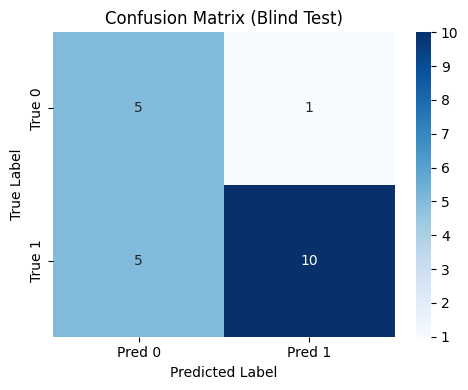


Saved files in: /content/outputs_nested_outer_repkfold_top5_cls_FPonly_notuned/confmat_outputs


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# --- CONFIG ---
EXP_PATH  = "expt-dff.xlsx"
PRED_PATH = "outputs_nested_outer_repkfold_top5_cls_FPonly_notuned/blind_ensemble.csv"
LABEL_COL = "Cmpd Label"
CUTOFF    = 0.3    # dF/F >= 0.3 → class 1
THRESH    = 0.5    # probability threshold for classification

# --- Output folder next to predictions file ---
out_dir = Path(PRED_PATH).parent / "confmat_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

# --- Load experimental ground truth ---
exp_raw = pd.read_excel(EXP_PATH, header=None)
df_exp = exp_raw.rename(columns={0: LABEL_COL, 1: "dFF_expt"})
df_exp[LABEL_COL] = df_exp[LABEL_COL].astype(str)
df_exp["y_true"]  = (df_exp["dFF_expt"].astype(float) >= CUTOFF).astype(int)

# --- Load predictions ---
pred = pd.read_csv(PRED_PATH)
pred[LABEL_COL] = pred[LABEL_COL].astype(str)

if "Ensemble_vote" in pred.columns:
    y_pred = pred["Ensemble_vote"].astype(int).values
    y_prob = pred["Ensemble_mean"].values if "Ensemble_mean" in pred.columns else None
else:
    y_prob = pred["Ensemble_mean"].astype(float).values
    y_pred = (y_prob >= THRESH).astype(int)

# --- Align by label ---
merged = df_exp[[LABEL_COL, "y_true"]].merge(pred, on=LABEL_COL, how="inner")
if "Ensemble_vote" in merged.columns:
    y_pred = merged["Ensemble_vote"].astype(int).values
else:
    y_prob = merged["Ensemble_mean"].astype(float).values
    y_pred = (y_prob >= THRESH).astype(int)
y_true = merged["y_true"].values

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (rows=true, cols=pred):")
print(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0","Class 1"], digits=3))

# --- SAVE: counts (matrix style) ---
counts_df = pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])
counts_df.to_csv(out_dir / "confusion_matrix_counts.csv", index=True)

# --- SAVE: long table (for Origin heatmap) ---
long_df = counts_df.reset_index().melt(id_vars="index",
                                       var_name="Pred",
                                       value_name="Count").rename(columns={"index": "True"})
long_df.to_csv(out_dir / "confusion_matrix_long_for_origin.csv", index=False)

# --- SAVE: y_true / y_pred pairs ---
pairs_df = pd.DataFrame({LABEL_COL: merged[LABEL_COL],
                         "y_true": y_true,
                         "y_pred": y_pred})
pairs_df.to_csv(out_dir / "y_true_pred_pairs.csv", index=False)

# --- SAVE: classification report (CSV) ---
report_dict = classification_report(y_true, y_pred, target_names=["Class 0","Class 1"], output_dict=True)
pd.DataFrame(report_dict).to_csv(out_dir / "classification_report.csv")

# --- SAVE: compact TN/FP/FN/TP summary ---
pd.DataFrame([{"TN": tn, "FP": fp, "FN": fn, "TP": tp}]).to_csv(out_dir / "confusion_summary.csv", index=False)

# --- Plot & SAVE figure ---
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=["Pred 0","Pred 1"],
                 yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix (Blind Test)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig(out_dir / "confusion_matrix_blind.png", dpi=300)
plt.show()

print(f"\nSaved files in: {out_dir.resolve()}")



# regression only fps no tuning

In [ ]:
# -*- coding: utf-8 -*-
"""
Regression (SVR), FP-only, NO HYPERPARAMETER TUNING.
Outer = RepeatedKFold (5 folds × 5 repeats) compares fingerprint × kernel families.
NO inner GridSearch — uses fixed defaults (C=1.0, epsilon=0.1, gamma='scale').

After evaluating all families:
  - Pick Top-5 by outer mean R^2 (tie-break: lower RMSE mean),
  - Report Top-K outer R^2 mean/std + RMSE/MAE,
  - Refit each Top-K on ALL data with the fixed params,
  - Save models + params,
  - Predict blind per-model and ensemble.

Features: fingerprint bits ONLY (no HOMO/LUMO).
"""

from pathlib import Path
import sys, json
import numpy as np
import pandas as pd

from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg

from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# ---------------- CONFIG ----------------
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"   # training (63) — will use only Smiles + dFF
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"

NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"
NEW_SMILES    = "Smiles"
NEW_LABEL_COL = "Cmpd Label"

OUT_DIR = Path("outputs_repkfold_top5_reg_FPonly_notuned")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FP_SIZE  = 2048
MORGAN_R = 2
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Outer CV
OUTER_FOLDS   = 5
OUTER_REPEATS = 5
RANDOM_SEED   = 0

# Fixed default params (NO tuning)
DEF_PARAMS = {
    "linear":  {"kernel": "linear",  "C": 1.0, "epsilon": 0.1},
    "rbf":     {"kernel": "rbf",     "C": 1.0, "epsilon": 0.1, "gamma": "scale"},
    "sigmoid": {"kernel": "sigmoid",  "C": 1.0, "epsilon": 0.1, "gamma": "scale"},
}

TOP_K = 5

# ---------------- Fingerprints ----------------
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name):
    if fp_name == "Morgan": fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS": fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs": fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion": fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon": fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight": fps = [fp_bits_daylight(m) for m in mols]
    else: raise ValueError(fp_name)
    return bitvects_to_numpy(fps, fp_size=len(fps[0]))

# ---------------- Evaluation ----------------
def evaluate_family(X, y, kernel):
    params = DEF_PARAMS[kernel]
    rkf = RepeatedKFold(n_splits=OUTER_FOLDS, n_repeats=OUTER_REPEATS, random_state=RANDOM_SEED)
    r2s, rmses, maes = [], [], []

    for tr, te in rkf.split(X, y):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        mdl = SVR(**params)
        mdl.fit(Xtr, ytr)
        y_pred = mdl.predict(Xte)

        r2s.append(r2_score(yte, y_pred))
        rmses.append(np.sqrt(mean_squared_error(yte, y_pred)))
        maes.append(mean_absolute_error(yte, y_pred))

    return {
        "outer_r2_mean": float(np.mean(r2s)),
        "outer_r2_std":  float(np.std(r2s)),
        "outer_rmse_mean": float(np.mean(rmses)),
        "outer_rmse_std":  float(np.std(rmses)),
        "outer_mae_mean":  float(np.mean(maes)),
        "outer_mae_std":   float(np.std(maes)),
    }

# ---------------- Main ----------------
def main():
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols   = [Chem.MolFromSmiles(s) for s in smiles]
    y      = df[TARGET_COL].astype(float).values

    rows = []
    for fp in FINGERPRINTS:
        X = build_features(mols, fp)
        for kernel in KERNELS:
            res = evaluate_family(X, y, kernel)
            rows.append({
                "fingerprint": fp, "kernel": kernel,
                "outer_r2_mean": res["outer_r2_mean"], "outer_r2_std": res["outer_r2_std"],
                "outer_rmse_mean": res["outer_rmse_mean"], "outer_rmse_std": res["outer_rmse_std"],
                "outer_mae_mean": res["outer_mae_mean"], "outer_mae_std": res["outer_mae_std"],
            })

    summary = pd.DataFrame(rows).sort_values(
        by=["outer_r2_mean", "outer_rmse_mean"], ascending=[False, True]
    ).reset_index(drop=True)
    summary.to_csv(OUT_DIR / "summary_repkfold_families.csv", index=False)
    print("\nTop families by outer mean R^2 (NO TUNING):")
    print(summary.head(12))

    # Top-K
    topk = summary.head(TOP_K).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))

    enriched_rows = []
    saved = []
    for _, row in topk.iterrows():
        fp, kernel = row["fingerprint"], row["kernel"]
        params = DEF_PARAMS[kernel]

        X_all = build_features(mols, fp)
        mdl = SVR(**params).fit(X_all, y)
        tag = f"{fp}_{kernel}".replace(" ", "")
        model_path = OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}.joblib"
        dump(mdl, model_path)

        enriched_rows.append({
            "rank": int(row["rank"]),
            "fingerprint": fp,
            "kernel": kernel,
            "outer_r2_mean": float(row["outer_r2_mean"]),
            "outer_r2_std": float(row["outer_r2_std"]),
            "outer_rmse_mean": float(row["outer_rmse_mean"]),
            "outer_rmse_std": float(row["outer_rmse_std"]),
            "outer_mae_mean": float(row["outer_mae_mean"]),
            "outer_mae_std": float(row["outer_mae_std"]),
            "C": params.get("C"),
            "epsilon": params.get("epsilon"),
            "gamma": params.get("gamma", None),
        })

        saved.append((model_path, fp, kernel, params))
        print(f"Saved: {model_path} params={params}")

    topk_enriched = pd.DataFrame(enriched_rows).sort_values("rank")
    topk_enriched.to_csv(OUT_DIR / "top_models.csv", index=False)

    # Blind predictions
    if NEW_CSV is not None:
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok = [m is not None for m in new_mols]
        bdf = bdf.loc[ok].reset_index(drop=True)
        new_mols = [m for m, t in zip(new_mols, ok) if t]

        per_cols = {}
        for path, fp, kernel, params in saved:
            mdl = load(path)
            X_new = build_features(new_mols, fp)
            y_pred = mdl.predict(X_new)
            per_cols[Path(path).stem] = y_pred

        per_df = pd.DataFrame(per_cols)
        per_df.insert(0, NEW_LABEL_COL, bdf[NEW_LABEL_COL].values)
        per_df.to_csv(OUT_DIR / "blind_per_model.csv", index=False)

        P = np.column_stack([per_cols[c] for c in per_cols.keys()]) if per_cols else np.zeros((len(bdf), 0))
        ens_df = pd.DataFrame({
            NEW_LABEL_COL: bdf[NEW_LABEL_COL].values,
            "Ensemble_mean":   P.mean(axis=1) if P.size else np.zeros(len(bdf)),
            "Ensemble_median": np.median(P, axis=1) if P.size else np.zeros(len(bdf)),
            "Ensemble_std":    P.std(axis=1, ddof=1) if P.shape[1] > 1 else (np.zeros(len(bdf)) if P.size else np.zeros(len(bdf)))
        })
        ens_df.to_csv(OUT_DIR / "blind_ensemble.csv", index=False)
        print(f"Saved: {OUT_DIR/'blind_per_model.csv'}")
        print(f"Saved: {OUT_DIR/'blind_ensemble.csv'}")

    print("\nDone.")

if __name__ == "__main__":
    main()


Top families by outer mean R^2 (NO TUNING):
   fingerprint   kernel  outer_r2_mean  outer_r2_std  outer_rmse_mean  \
0      Torsion   linear       0.402880      0.253646         0.409731   
1    AtomPairs   linear       0.396419      0.227162         0.415469   
2      Torsion  sigmoid       0.344453      0.202557         0.439904   
3     Daylight   linear       0.322060      0.353554         0.440084   
4        MACCS      rbf       0.302713      0.184572         0.457569   
5       Avalon   linear       0.300734      0.310164         0.440567   
6       Morgan  sigmoid       0.267671      0.158200         0.467449   
7      Torsion      rbf       0.262062      0.159202         0.473642   
8        MACCS  sigmoid       0.255694      0.171987         0.475995   
9    AtomPairs  sigmoid       0.247977      0.174266         0.479745   
10   AtomPairs      rbf       0.201370      0.162270         0.494806   
11      Morgan   linear       0.174953      0.303195         0.484773   

    o